In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
%matplotlib inline

In [2]:
# read in 'corpora' files, dictionaries, and convert them to dfs
frame_one = pd.DataFrame(
    pd.read_pickle('/home/elrazia/rap_lyrics/notebooks/corpora/corpus_one.pkl')).T.reset_index()
frame_two = pd.DataFrame(
    pd.read_pickle('/home/elrazia/rap_lyrics/notebooks/corpora/corpus_two.pkl')).T.reset_index()
frame_three = pd.DataFrame(
    pd.read_pickle('/home/elrazia/rap_lyrics/notebooks/corpora/corpus_three.pkl')).T.reset_index()
frame_four = pd.DataFrame(
    pd.read_pickle('/home/elrazia/rap_lyrics/notebooks/corpora/corpus_four.pkl')).T.reset_index()

In [36]:
# concat four frames into one big dataframe, 'rap_frame'
rap_frame = pd.concat([frame_one, frame_two, frame_three, frame_four]).reset_index()
rap_frame = rap_frame.drop('index', axis=1)

## Cleaning frame

In [37]:
rap_frame.columns = ['title', 'artist', 'date', 'lyrics']

In [38]:
def year_grab(date_array):
    
    ''' Takes in array of dates, returns new array containing only year'''
    
    new_dates = []
    for date in date_array:
        if len(date)>0:
            new_dates.append(int(date.strip().split(', ')[1]))
        else:
            new_dates.append(date)
    return new_dates

In [39]:
# convert 'date' column to only year values
rap_frame['date'] = year_grab(rap_frame.date)

In [40]:
# drop rows with release dates prior to 1980
rap_frame = rap_frame[rap_frame.date > 1980]

In [15]:
with open('rap_frame.pkl', 'wb') as writefile:
    pickle.dump(rap_frame, writefile)

In [41]:
# column for main artist, ignoring featured artists
rap_frame['primary'] = rap_frame['artist'].apply(lambda x: x[0])

In [42]:
# create separate df with value counts
counts_df = rap_frame['primary'].value_counts()

value_frame = pd.DataFrame({ 'primary': counts_df.index.tolist(), 
                             'counts': counts_df.values.tolist() })

In [43]:
# merge two dfs to add 'primary artist' and 'value counts' columns
rap_frame = pd.merge(rap_frame,value_frame, on='primary')

In [44]:
# exclude artists who appear in less than 10 songs
rap_frame = rap_frame[rap_frame['counts'] > 10]

## Initial K-Means

#### Vectorizing

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [46]:
# English + custom stopwords
stopwords = set(ENGLISH_STOP_WORDS.copy())
stopwords.update(['bitch', 'fuck', 'nigga', 'niggas', 'motherfucker'])

In [47]:
tvectorizer = TfidfVectorizer(analyzer='word', min_df=.01, max_df=1000, max_features=20000, 
                              stop_words=stopwords)
tfidf = tvectorizer.fit_transform(rap_frame['lyrics'])

#### PCA

In [48]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
prin_var = pca.fit(tfidf.toarray()) 
principal = pca.fit_transform(tfidf.toarray())
pvars = prin_var.explained_variance_

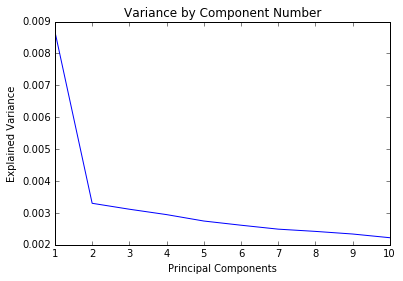

In [50]:
plt.plot(range(1,len(pvars)+1),pvars)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance')
plt.title('Variance by Component Number')

In [51]:
# Elbow method: 2 components explain majority of variance
pca = PCA(n_components=2)
prin_var = pca.fit(tfidf.toarray()) 
principal = pca.fit_transform(tfidf.toarray())

#### KMEANS

In [52]:
from sklearn.cluster import KMeans

In [53]:
# determine number of clusters
n_inertia = []
for i in range(1,15):
    km = KMeans(n_clusters = i, init = 'k-means++', n_init=25, n_jobs=-1)
    kmeans_pca_array = km.fit_transform(principal)
    pca_clusters_array = km.predict(principal)
    inertia = km.inertia_
    n_inertia.append(inertia)

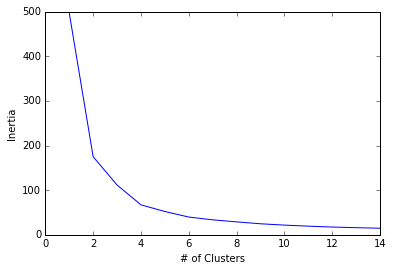

In [55]:
plt.xlabel('# of Clusters')
plt.ylabel('Inertia')
plt.plot(range(1,15),n_inertia)

In [56]:
# fit model with 4 clusters
model = KMeans(n_clusters=4).fit(principal)
kmean = model.predict(principal)
rap_frame['kmean_pca'] = kmean

In [58]:
rap_frame.kmean_pca.value_counts()

0    23389
2    17195
1      576
3      316
Name: kmean_pca, dtype: int64

In [68]:
rap_frame[rap_frame['kmean_pca'] == 2].primary.value_counts().head()

Eminem            311
Nas               288
Tech N9ne         264
Lil Wayne         236
Kendrick Lamar    219
Name: primary, dtype: int64

In [154]:
rap_frame[rap_frame['kmean_pca'] == 0]

,title,artist,date,lyrics,primary,counts,kmean_pca
251,398,"[Jay Z, The Notorious B.I.G....",2002,[Refrain: Faith Evans]. Last night I had a dre...,Jay Z,335,0
269,4296,"[Jay Z, Lenny Kravitz ...",2002,Come on. Ha hey yo stop playin man. This is re...,Jay Z,335,0
301,98,"[Jay Z, E*Vax ]",,"""I've been in several things, I was in the dru...",Jay Z,335,0
308,407,"[Jay Z, The Notorious B.I.G....",2002,[Refrain: Faith Evans]. Last night I had a dre...,Jay Z,335,0
363,4246,"[Jay Z, Lenny Kravitz ...",2002,Come on. Ha hey yo stop playin man. This is re...,Jay Z,335,0
457,10952,"[Jay Z, Timbaland ...",2013,"I wonder if you fools realize how far, you are...",Jay Z,335,0
472,358,"[Jay Z, The Notorious B.I.G....",2002,[Refrain: Faith Evans]. Last night I had a dre...,Jay Z,335,0
526,87,"[Jay Z, E*Vax ]",,"""I've been in several things, I was in the dru...",Jay Z,335,0
765,4820,"[Joe Budden, The Klasix ...",2009,(Cause) Snoop already told me that bitches ain...,Joe Budden,253,0
848,9235,"[Joe Budden, Jared F. ...",,"Autobiographical, I need my life to maybe hop ...",Joe Budden,253,0


First clustering put foreign songs in cluster 1. Removal and recluster to follow.

In [69]:
# remove foreign
rap_frame = rap_frame[rap_frame['kmean_pca'] != 1]

In [70]:
# re-vectorize
tvectorizer = TfidfVectorizer(analyzer='word', min_df=.01, max_df=1000, max_features=20000, 
                              stop_words=stopwords)
tfidf = tvectorizer.fit_transform(rap_frame['lyrics'])

In [72]:
# re-pca
pca = PCA(n_components=10)
prin_var = pca.fit(tfidf.toarray()) 
principal = pca.fit_transform(tfidf.toarray())
pvars = prin_var.explained_variance_

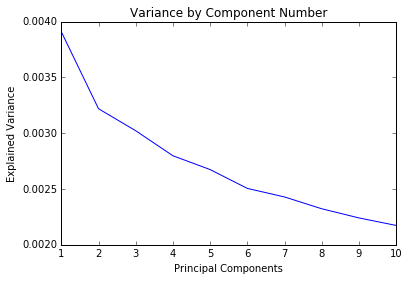

In [73]:
plt.plot(range(1,len(pvars)+1),pvars)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance')
plt.title('Variance by Component Number')

In [74]:
# Elbow method: 4 components explain majority of variance
pca = PCA(n_components=4)
prin_var = pca.fit(tfidf.toarray()) 
principal = pca.fit_transform(tfidf.toarray())

In [77]:
# re-kmeans
n_inertia = []
for i in range(1,15):
    km = KMeans(n_clusters = i, init = 'k-means++', n_init=25, n_jobs=-1)
    kmeans_pca_array = km.fit_transform(principal)
    pca_clusters_array = km.predict(principal)
    inertia = km.inertia_
    n_inertia.append(inertia)

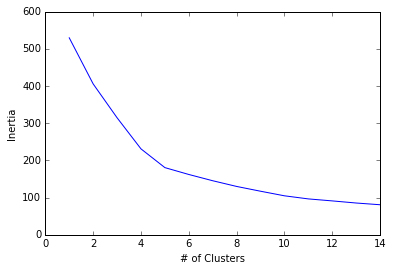

In [78]:
plt.xlabel('# of Clusters')
plt.ylabel('Inertia')
plt.plot(range(1,15),n_inertia)

In [79]:
# fit model with 5 clusters
model = KMeans(n_clusters=5).fit(principal)
kmean = model.predict(principal)
rap_frame['kmean_pca'] = kmean

In [80]:
rap_frame.kmean_pca.value_counts()

4    18234
3    12707
1     9261
0      417
2      281
Name: kmean_pca, dtype: int64

In [95]:
rap_frame[rap_frame['kmean_pca'] == 4].primary.value_counts().head()

Gucci Mane           302
Waka Flocka Flame    223
Young Thug           204
Lil Wayne            203
Chief Keef           194
Name: primary, dtype: int64

Second clustering appears to show temporal groupings. Group lyrics by decade, cluster again.

In [103]:
frame10 = rap_frame[(rap_frame['date'] >= 2010)]
frame00 = rap_frame[(rap_frame['date'] > 1999) & (rap_frame['date'] < 2010)]
frame90 = rap_frame[(rap_frame['date'] > 1989) & (rap_frame['date'] < 2000)]
frame80 = rap_frame[(rap_frame['date'] < 1990)]

In [104]:
tvectorizer10 = TfidfVectorizer(analyzer='word', min_df=.01, max_df=1000, max_features=20000, 
                              stop_words=stopwords)
tvectorizer00 = TfidfVectorizer(analyzer='word', min_df=.01, max_df=1000, max_features=20000, 
                              stop_words=stopwords)
tvectorizer90 = TfidfVectorizer(analyzer='word', min_df=.01, max_df=1000, max_features=20000, 
                              stop_words=stopwords)
tvectorizer80 = TfidfVectorizer(analyzer='word', min_df=.01, max_df=1000, max_features=20000, 
                              stop_words=stopwords)

tfidf10 = tvectorizer10.fit_transform(frame10['lyrics'])
tfidf00 = tvectorizer00.fit_transform(frame00['lyrics'])
tfidf90 = tvectorizer90.fit_transform(frame90['lyrics'])
tfidf80 = tvectorizer80.fit_transform(frame80['lyrics'])

In [105]:
# save for topic modeling
vocab10 = tvectorizer10.get_feature_names()
vocab00 = tvectorizer00.get_feature_names()
vocab90 = tvectorizer90.get_feature_names()
vocab80 = tvectorizer80.get_feature_names()

In [107]:
pca10 = PCA(n_components=8)
prin_var10 = pca.fit(tfidf10.toarray()) 
principal10 = pca.fit_transform(tfidf10.toarray())

pca00 = PCA(n_components=8)
prin_var00 = pca.fit(tfidf00.toarray()) 
principal00 = pca.fit_transform(tfidf00.toarray())

pca90 = PCA(n_components=8)
prin_var90 = pca.fit(tfidf90.toarray()) 
principal90 = pca.fit_transform(tfidf90.toarray())

pca80 = PCA(n_components=8)
prin_var80 = pca.fit(tfidf80.toarray()) 
principal80 = pca.fit_transform(tfidf80.toarray())

pvars10 = prin_var10.explained_variance_
pvars00 = prin_var00.explained_variance_
pvars90 = prin_var90.explained_variance_
pvars80 = prin_var80.explained_variance_

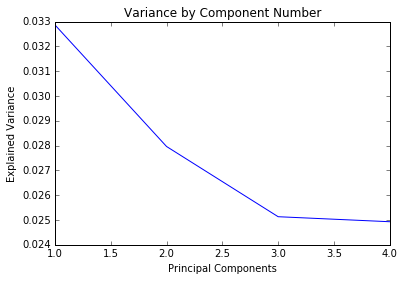

In [115]:
plt.plot(range(1,len(pvars80)+1),pvars80)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance')
plt.title('Variance by Component Number')

In [116]:
# 3 principal components explain majority of variance
pca10 = PCA(n_components=3)
prin_var10 = pca.fit(tfidf10.toarray()) 
principal10 = pca.fit_transform(tfidf10.toarray())

pca00 = PCA(n_components=3)
prin_var00 = pca.fit(tfidf00.toarray()) 
principal00 = pca.fit_transform(tfidf00.toarray())

pca90 = PCA(n_components=3)
prin_var90 = pca.fit(tfidf90.toarray()) 
principal90 = pca.fit_transform(tfidf90.toarray())

pca80 = PCA(n_components=3)
prin_var80 = pca.fit(tfidf80.toarray()) 
principal80 = pca.fit_transform(tfidf80.toarray())

In [117]:
n_inertia10 = []
for i in range(1,15):
    km = KMeans(n_clusters = i, init = 'k-means++', n_init=25, n_jobs=-1)
    kmeans_pca_array = km.fit_transform(principal10)
    pca_clusters_array = km.predict(principal10)
    inertia = km.inertia_
    n_inertia10.append(inertia)
    
n_inertia00 = []
for i in range(1,15):
    km = KMeans(n_clusters = i, init = 'k-means++', n_init=25, n_jobs=-1)
    kmeans_pca_array = km.fit_transform(principal00)
    pca_clusters_array = km.predict(principal00)
    inertia = km.inertia_
    n_inertia00.append(inertia)
    
n_inertia90 = []
for i in range(1,15):
    km = KMeans(n_clusters = i, init = 'k-means++', n_init=25, n_jobs=-1)
    kmeans_pca_array = km.fit_transform(principal90)
    pca_clusters_array = km.predict(principal90)
    inertia = km.inertia_
    n_inertia90.append(inertia)
    
n_inertia80 = []
for i in range(1,15):
    km = KMeans(n_clusters = i, init = 'k-means++', n_init=25, n_jobs=-1)
    kmeans_pca_array = km.fit_transform(principal80)
    pca_clusters_array = km.predict(principal80)
    inertia = km.inertia_
    n_inertia80.append(inertia)

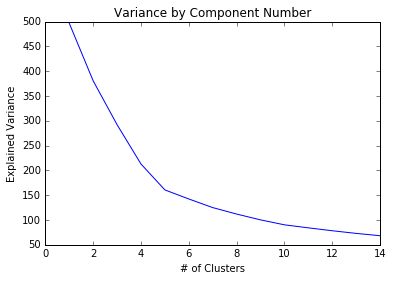

In [121]:
plt.plot(range(1,15),n_inertia10)
plt.xlabel('# of Clusters')
plt.ylabel('Explained Variance')
plt.title('Variance by Component Number')

In [124]:
# kmeans with 5 clusters
model10 = KMeans(n_clusters=5).fit(principal10)
model00 = KMeans(n_clusters=5).fit(principal00)
model90 = KMeans(n_clusters=5).fit(principal90)
model80 = KMeans(n_clusters=5).fit(principal80)

kmean10 = model.predict(principal10)
kmean00 = model.predict(principal00)
kmean90 = model.predict(principal90)
kmean80 = model.predict(principal80)

In [126]:
frame10['kmean_pca'] = kmean10
frame00['kmean_pca'] = kmean00
frame90['kmean_pca'] = kmean90
frame80['kmean_pca'] = kmean80

In [161]:
frame90.kmean_pca.value_counts()

4    498
1    461
3    396
Name: kmean_pca, dtype: int64

In [164]:
frame90[frame90['kmean_pca'] == 4].primary.value_counts().head()

Nas                 47
Raekwon             37
Big Daddy Kane      31
Ghostface Killah    23
Redman              22
Name: primary, dtype: int64

80s and 90s artists clustering by rap group, 00s only shady records cluster, 10s no clusters by group.

## Topic Modeling

#### NMF

In [165]:
from sklearn.decomposition import NMF

In [183]:
n_topics = 5
n_top_words = 10

In [167]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [184]:
nmf10 = NMF(n_components=n_topics, alpha=.1, l1_ratio=.5).fit(tfidf10)
nmf00 = NMF(n_components=n_topics, alpha=.1, l1_ratio=.5).fit(tfidf00)
nmf90 = NMF(n_components=n_topics, alpha=.1, l1_ratio=.5).fit(tfidf90)
nmf80 = NMF(n_components=n_topics, alpha=.1, l1_ratio=.5).fit(tfidf80)

In [187]:
print_top_words(nmf90, vocab90, n_top_words)

Topic #0:
got cause don shit know ain yo man just ll
Topic #1:
dogg snoop doggy pound motherfuckin cuz nate loc gangsta hey
Topic #2:
ha cryin biz lovin nothin somethin handle paper sho far
Topic #3:
biggie smalls ron rappin rum big weed brooklyn chance oh
Topic #4:
funk redman swing sweet style ride stop let pack trunk
()
